# Node level prediction on Cora using GCN
- toc: True
- categorites: [Graph Machine Learning] 

## Data Loading and Preprocessing

In [1]:
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import torch_geometric.loader as loader
from torch_geometric.datasets import Planetoid
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [2]:
name = 'Cora'
transform = transforms.Compose([
    transforms.RandomNodeSplit('train_rest', num_val=500, num_test=500),
    transforms.TargetIndegree()
])
cora = datasets.Planetoid('./data', name, pre_transform=transforms.NormalizeFeatures(), transform=transform)
# pre_transform applied only when the dataset is downloading
# once dataeset is downloaded the transforms will be applies 
# if dataset is already downloaded the running cell again will retrive dataset from the local it self

In [3]:
print("Cora info:")
print("# of graphs:", len(cora))
print("# Classes {graphs}", cora.num_classes)
print("# Edge features", cora.num_edge_features)
print("# Node features", cora.num_node_features)

Cora info:
# of graphs: 1
# Classes {graphs} 7
# Edge features 1
# Node features 1433


In [4]:
first = cora[0]
print("Number of nodes: ", first.num_nodes)
print("Number of edges: ", first.num_edges)
print("Is directed: ", first.is_directed())

Number of nodes:  2708
Number of edges:  10556
Is directed:  True


In [5]:
print("Shape of sample nodes: ", first.x[:5].shape)

Shape of sample nodes:  torch.Size([5, 1433])


In [6]:
print("# of nodes to train on: ", first.train_mask.sum().item())

print("# of nodes to test on: ", first.test_mask.sum().item())

print("# of nodes to validate on: ", first.val_mask.sum().item())

# of nodes to train on:  1708
# of nodes to test on:  500
# of nodes to validate on:  500


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## GCN model preparation

In [8]:
device

device(type='cuda')

In [9]:
data = cora[0].to(device)

In [10]:
print("X shape: ", data.x.shape)
print("Edge shape: ", data.edge_index.shape)
print("Y shape: ", data.y.shape)

X shape:  torch.Size([2708, 1433])
Edge shape:  torch.Size([2, 10556])
Y shape:  torch.Size([2708])


In [11]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        """ GCNConv layers """
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, cora.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [12]:
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [13]:
def compute_accuracy(pred_y, y):
    return (pred_y == y).sum()

In [17]:
model.train()
losses = []
accuracies = []
for epoch in range(400):
    optimizer.zero_grad()
    out = model(data)

    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    correct = compute_accuracy(out.argmax(dim=1)[data.train_mask], data.y[data.train_mask])
    acc = int(correct) / int(data.train_mask.sum())
    losses.append(loss.item())
    accuracies.append(acc)

    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print('Epoch: {}, Loss: {:.4f}, Training Acc: {:.4f}'.format(epoch+1, loss.item(), acc))

Epoch: 10, Loss: 0.7428, Training Acc: 0.8337
Epoch: 20, Loss: 0.7433, Training Acc: 0.8144
Epoch: 30, Loss: 0.7336, Training Acc: 0.8203
Epoch: 40, Loss: 0.7138, Training Acc: 0.8279
Epoch: 50, Loss: 0.6708, Training Acc: 0.8495
Epoch: 60, Loss: 0.6556, Training Acc: 0.8472
Epoch: 70, Loss: 0.6460, Training Acc: 0.8413
Epoch: 80, Loss: 0.6598, Training Acc: 0.8372
Epoch: 90, Loss: 0.6431, Training Acc: 0.8454
Epoch: 100, Loss: 0.6235, Training Acc: 0.8513
Epoch: 110, Loss: 0.6280, Training Acc: 0.8525
Epoch: 120, Loss: 0.6283, Training Acc: 0.8525
Epoch: 130, Loss: 0.5984, Training Acc: 0.8595
Epoch: 140, Loss: 0.6113, Training Acc: 0.8525
Epoch: 150, Loss: 0.5999, Training Acc: 0.8671
Epoch: 160, Loss: 0.5997, Training Acc: 0.8484
Epoch: 170, Loss: 0.5856, Training Acc: 0.8612
Epoch: 180, Loss: 0.5930, Training Acc: 0.8642
Epoch: 190, Loss: 0.5878, Training Acc: 0.8519
Epoch: 200, Loss: 0.5753, Training Acc: 0.8642
Epoch: 210, Loss: 0.5832, Training Acc: 0.8519
Epoch: 220, Loss: 0.56

## Training Results

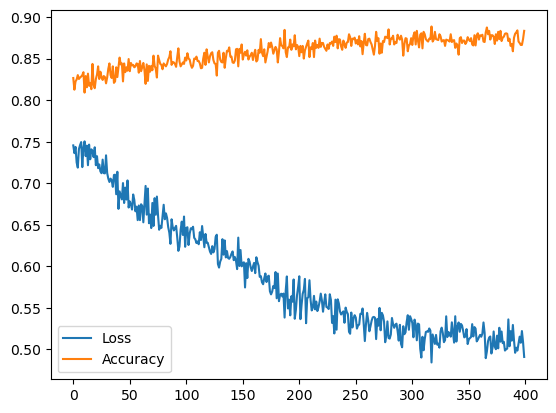

In [18]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(accuracies)
plt.legend(['Loss', 'Accuracy'])
plt.show()

In [19]:
model.eval()
pred = model(data).argmax(dim=1)
correct = compute_accuracy(pred[data.test_mask], data.y[data.test_mask])
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8900
